In [1]:
import os
import sys
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from IPython import display

import torch
from torchvision.transforms import transforms

# Define the module path so that we can call our own helper functions
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.utilities.utils import get_image_paths, variance_of_laplacian

In [2]:
# Get project directory 
PROJ_DIR = os.path.abspath(os.path.join(".."))

# 1.0-Data-analysis

This notebook aims to perform the data analysis for our project. For this case, we are performing Exploratory Data Analysis (EDA). This is where we analyze our dataset to answer our preliminary questions and to guide the modelling process. 

What we want to achieve in this step is to understand the specifics of our dataset. Luckily, we are provided with a dataset of imagery, pre-organized into folders, named as the reespective age each example represents. This means that no annotation is required for this step.

For this step, we hope to identify anomalies, understand the data distribution and gain insights for further model. This will influence our decisions in the preprocessing pipeline, architecture selection, etc.

## 1.1 Image Statistics
### Extract the image paths

First we need to extract all the paths for the imagery in our dataset

In [3]:
dataset_dir = os.path.join(PROJ_DIR, "data", "raw", "dataset")
image_list = get_image_paths(dataset_dir)

print(f"Total images: {len(image_list)}")

Total images: 29970


In file explorer, it states that there are actually 29979 files in total. After exploration it was found that the files not included in this list are MAC related _DS_STORE files

Since we have a GPU available, we will be using the pytorch library to perform the operations on the gpu. Note that we iteratively store the summation of images in order to not store each image tensor in memory

In [4]:
# Setting device on GPU if available, else CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
image_means = torch.Tensor([0., 0. ,0.]).to(device)
image_stds = torch.Tensor([0., 0., 0.]).to(device)
statistics = []
image_id = 0

In [6]:
# Iterate through all the image to extract their information
for path in tqdm(image_list):
    # Load the next image
    image = Image.open(path)
    
    # Some examples are by default grayscale (image_mode = "L"), let's convert these to RGB but also record it's initial mode. 
    image_mode = image.mode
    if image_mode == "L":
        image = image.convert("RGB")
    
    # Convert the image to shape (channel, height, width). Automatically divides values by 255.
    image_tensor = transforms.ToTensor()(image).to(device)
    
    # Extract the mean and standard deviation
    mean = image_tensor.mean(dim=(1,2))
    image_means += mean
    
    st_dev = image_tensor.view(3, -1).std(dim=-1)
    image_stds += st_dev 
    
    # Record the values we wish to analyze later
    stat = {
        "image_id": image_id,
        "filename": path.rpartition('\\')[-1].split('.')[0],
        "path": path,
        "height": image.height,
        "width": image.width,
        "size": os.path.getsize(path),
        "image_mean([R,G,B])": mean.tolist(),
        "st_dev([R,G,B])": st_dev.tolist(),
        "image_mode": image_mode,
        "age": os.path.basename(os.path.split(path)[-2])
    }
    
    statistics.append(stat)
    
    image.close()
    
    # Update image_id
    image_id += 1
    

100%|██████████| 29970/29970 [07:17<00:00, 68.51it/s]


In [7]:
df = pd.DataFrame(statistics)
df["aspect_ratio"] = df["width"] / df["height"]
df

,image_id,filename,path,height,width,size,"image_mean([R,G,B])","st_dev([R,G,B])",image_mode,age,aspect_ratio
0,0,122542,C:\Users\Jared\projects\python\braineye-age-pr...,128,128,8652,"[0.6380450129508972, 0.31967222690582275, 0.28...","[0.1845678985118866, 0.18805555999279022, 0.17...",RGB,20,1.0
1,1,122550,C:\Users\Jared\projects\python\braineye-age-pr...,128,128,9781,"[0.3353889286518097, 0.2767695486545563, 0.202...","[0.275545597076416, 0.19257135689258575, 0.186...",RGB,20,1.0
2,2,122573,C:\Users\Jared\projects\python\braineye-age-pr...,128,128,7770,"[0.6544163227081299, 0.6315654516220093, 0.548...","[0.25599220395088196, 0.2756023705005646, 0.24...",RGB,20,1.0
3,3,122642,C:\Users\Jared\projects\python\braineye-age-pr...,128,128,4804,"[0.22364862263202667, 0.18860989809036255, 0.1...","[0.10604064166545868, 0.08799631893634796, 0.0...",RGB,20,1.0
4,4,122646,C:\Users\Jared\projects\python\braineye-age-pr...,128,128,11211,"[0.44937387108802795, 0.43740808963775635, 0.3...","[0.2650805115699768, 0.27240049839019775, 0.28...",RGB,20,1.0
...,...,...,...,...,...,...,...,...,...,...,...
29965,29965,99814,C:\Users\Jared\projects\python\braineye-age-pr...,128,128,7910,"[0.17300859093666077, 0.12947949767112732, 0.1...","[0.20211130380630493, 0.16090622544288635, 0.1...",RGB,50,1.0
29966,29966,99819,C:\Users\Jared\projects\python\braineye-age-pr...,128,128,8559,"[0.1891694962978363, 0.1776348054409027, 0.218...","[0.23028673231601715, 0.21333780884742737, 0.2...",RGB,50,1.0
29967,29967,99907,C:\Users\Jared\projects\python\braineye-age-pr...,128,128,6876,"[0.5533868670463562, 0.5229092836380005, 0.292...","[0.2174087017774582, 0.2374659925699234, 0.233...",RGB,50,1.0
29968,29968,99983,C:\Users\Jared\projects\python\braineye-age-pr...,128,128,10369,"[0.48215118050575256, 0.3947139084339142, 0.33...","[0.3137766718864441, 0.267193078994751, 0.2336...",RGB,50,1.0


In [8]:
# Let's save the DataFrame
df_path = os.path.join(PROJ_DIR, "data", "image_statistics.csv")
df.to_csv(df_path)

Initially deployment of the above cell had issues with a getting the mean and standard deviation of an image. This was due to the fact that it was read by default as a Grayscale image. Let's see if there are anymore of these types of examples within the dataset.

In [9]:
df.image_mode.value_counts()



image_mode
RGB    29969
L          1
Name: count, dtype: int64

Using all examples, we can calculate the mean and standard deviation that we collected before (note: to calculate the mean and std from a subset of the dataset,i.e. filtered examples, we can use the df).

Also note that by calling ```torchvision.transforms.ToTensor```, the pixels are divided automatically by 255.

In [10]:
print(image_means / len(image_list))
print(image_stds / len(image_list))

tensor([0.4502, 0.3783, 0.3373], device='cuda:0')
tensor([0.2486, 0.2242, 0.2153], device='cuda:0')


What we can see here is that the mean for the red channel is higher than the green and blue channels, and is closer to the middle of range of values (i.e. 0-255) than blue is. What's even more interesting is that the standard deviation channel values are all low and relatively close to each other. This indicates that there is a low variance across three channels (RGB), meaning that all the channel values reside somewhat closely to the mean.


## Distribution of Age

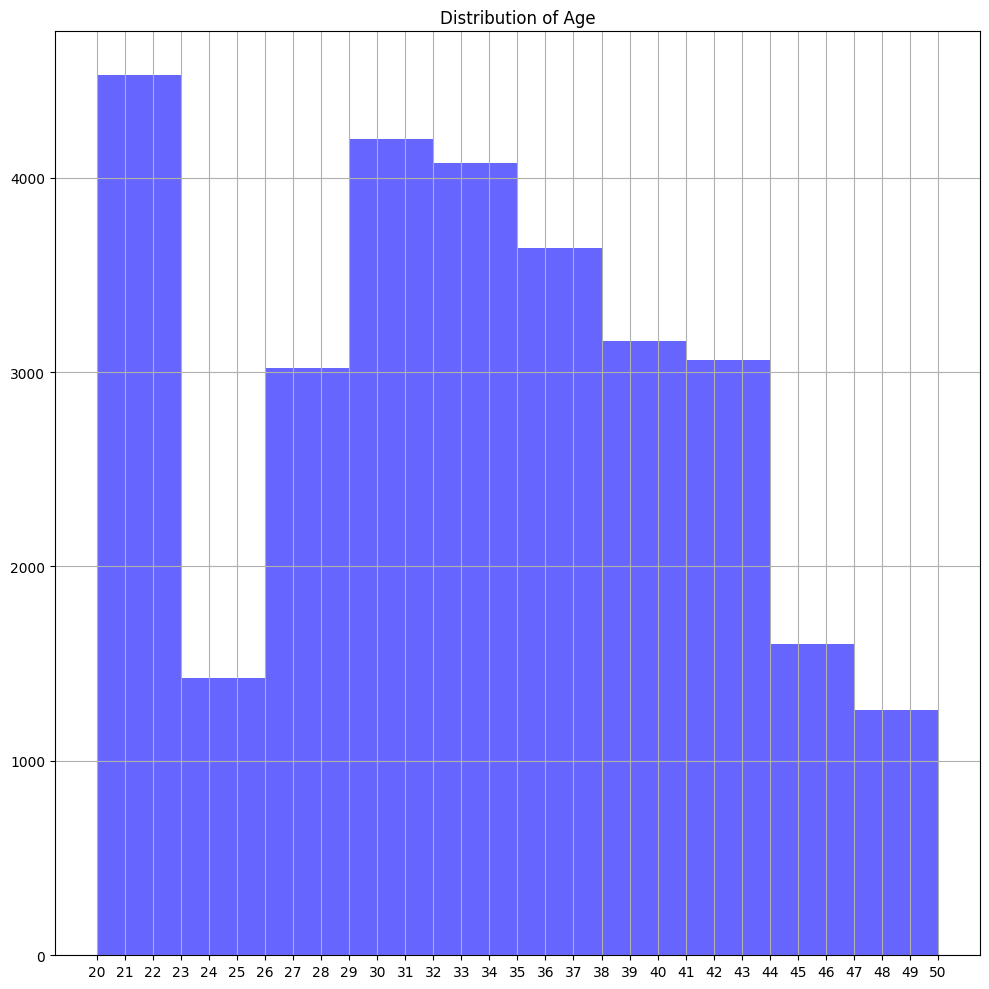

In [11]:
plt.figure(figsize=(10,10))
df["age"].hist(color="blue", alpha=0.6)

plt.title("Distribution of Age")
plt.tight_layout()
plt.show()

## Distribution of width and height

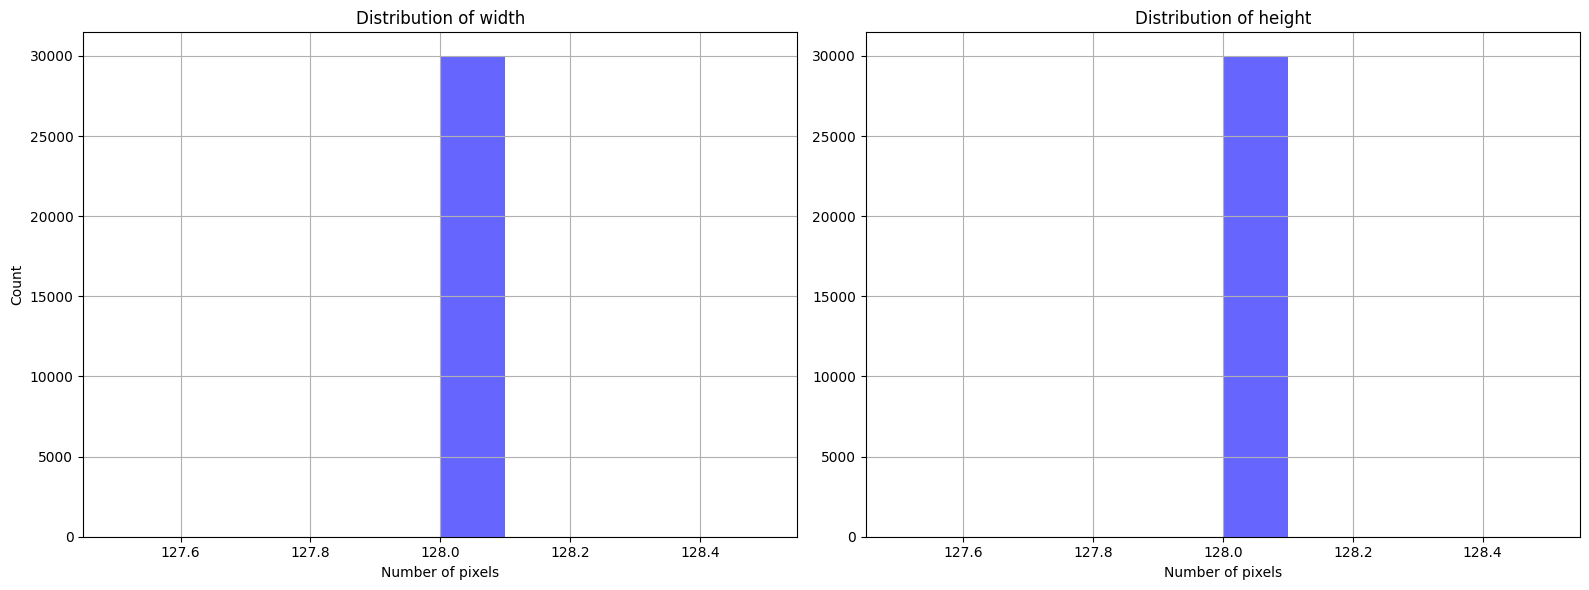

In [13]:
f, (ax1, ax2) = plt.subplots(1 ,2, figsize=(16,6))
df['width'].hist(ax=ax1, color='blue', alpha=0.6)
df['height'].hist(ax=ax2, color='blue', alpha=0.6)

ax1.set_title('Distribution of width')
ax2.set_title('Distribution of height')

ax1.set_xlabel("Number of pixels")
ax2.set_xlabel("Number of pixels")

ax1.set_ylabel("Count")

plt.tight_layout()
plt.show()

From this, we can see that the dataset has a consistent width and height distribution. We can expect this means that the aspect ratio is consistent throughout the dataset. Let's further verify this

In [14]:
df.aspect_ratio.value_counts()

aspect_ratio
1.0    29970
Name: count, dtype: int64

This indicates that the resolution of the imagery in the dataset is consistent. An indicator that this isn't a quality that we can use to determine the image quality in the dataset.

## Image Quality

Image quality plays a big part in a ML/DL dataset. Bad examples can poisons a models ability to learn the desired patterns and therefore limit a models ability to perform for its desired purpose. "Low image quality" is a prime example for a bad data point in a dataset. There are various ways to filter out low quality images in a dataset. Below are some the techniques


### Image Quality Metrics

Some of the classic indicators for poor image quality is the presence of blur, noise and over/underexposure. Let's look at some ways to detect and filt these if possible.



•	Bluriness detection: Use the Laplacian variance method to detect blurry images (threshold based)
•	Noise Detection: Use metrics like Peak Signal-to-Noise Ratio (PSNR) or Structural Similarity index (SSIM) to detect noisy images or similar.
•	Brightness and Contrast: Analyze the histogram of pixel values to detect images that are too dark or bright
 ---- Can use the distribution of mean and std to determine this?




### Blurriness detection

Blur can be detected in the image by calculating the variance of the laplacian of the input image. The Laplacian of the image is the 2nd spatial derivative of an image. It measures rapid intensity change and can be used to measure edges. Since the output is now an "edged" image, a small variance would indicate a small or nonexistent presence of edges.

In [15]:
# Compute the Laplacian variance and store it in the dataframe
all_lap_var = []
for i, path in tqdm(enumerate(df.path), total=len(df.path)):
    # Read image as cv2 image file
    img = cv2.imread(path)
    
    # Laplacian variance
    lp_var = variance_of_laplacian(img)
    
    all_lap_var.append(lp_var)
      
# Record the Laplacian variance in the DataFrame
df["laplacian_var"] = all_lap_var

100%|██████████| 29970/29970 [01:35<00:00, 312.69it/s] 


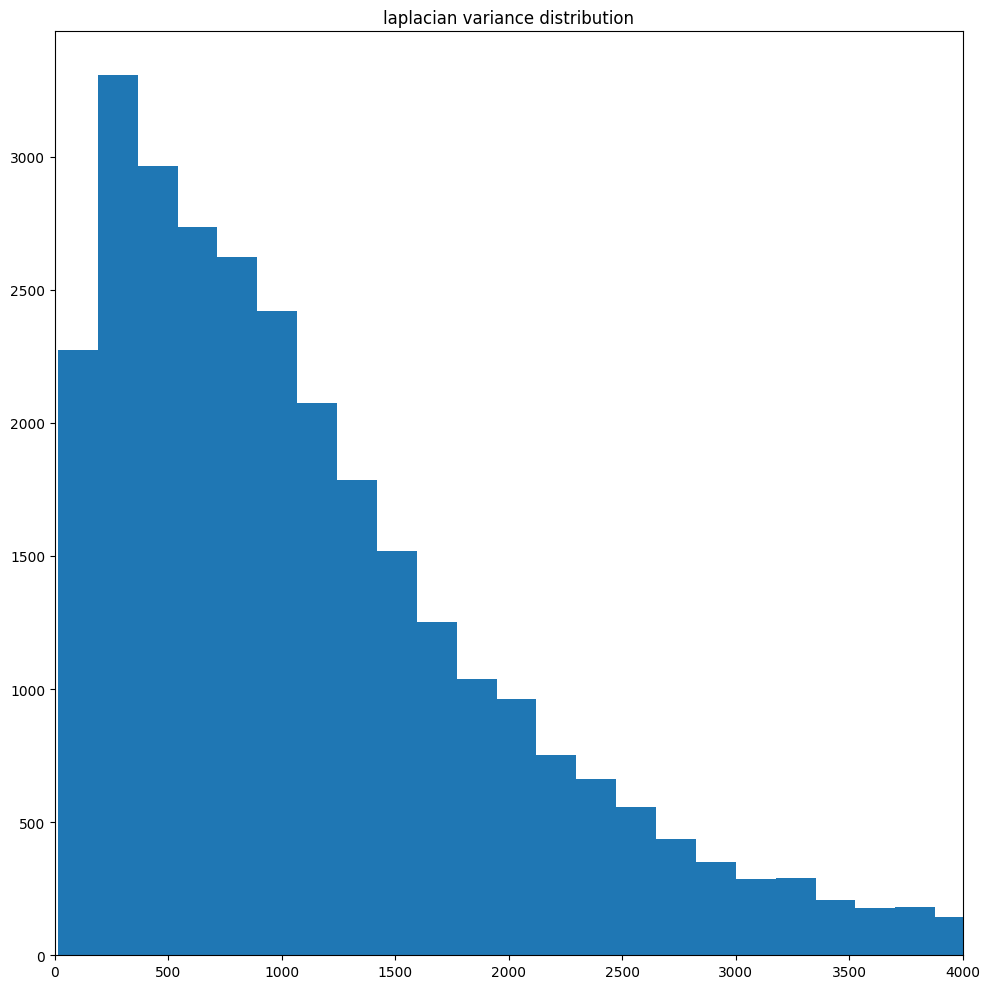

In [16]:
plt.figure(figsize=(10,10))
counts, edges, bars = plt.hist(df["laplacian_var"], bins=200)

plt.title("laplacian variance distribution")
plt.xlim([0, 4000])
plt.tight_layout()
plt.show()

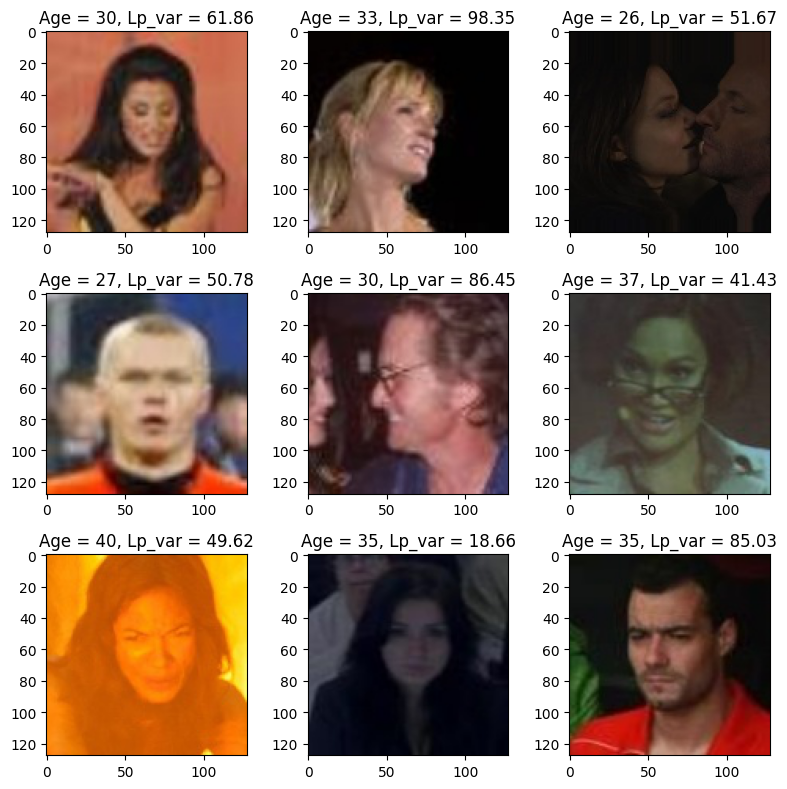

In [17]:
# Display images with low laplacian variances
# subset = df[(df.laplacian_var >= edges[0]) & (df.laplacian_var <= edges[1])]
subset = df[df.laplacian_var <= 100]
subset = subset.sample(n=9)

idx = 0
plt.figure(figsize=(8,8))

for i, display_path in enumerate(subset.path):
    display_img = Image.open(display_path)
    plt.subplot(3,3, i+1)
    plt.title(f"Age = {subset.age.iloc[i]}, Lp_var = {subset.laplacian_var.iloc[i]:.2f}")
    plt.imshow(display_img)
    
plt.tight_layout()
plt.show()
    



There is a significant amount of blur present in the images below a laplacian variance of 100. Originally, the edges of the histogram was used,however, there were some examples that was within this range and had a relatively okay "qaulity". That being said, there are the occasional example that doesn't look too blurry but may have been caught with a low value as their face may be obscurred (for various reasons such as positioning relative to the camera, shade, etc.) or their face/hair and other blend in well with the background, lowering the variance in the laplacian (second-order derivative) image.

### Brightness (Too bright or too dark)



In [18]:
# Calc cdf of histograms, and check the max and min examples. If really bright or dark proceed with a threshold finding
# def is_too_bright_or_dark(img, bright_threshol):
brightness_list = []
bright_threshold = 200 
dark_threshold = 50
bright_percentage = 0.73 # iteratively found
dark_percentage = 0.92


for i, image_path in tqdm(enumerate(df.path), total=len(df.path)):
    image = cv2.imread(image_path)
    
    # If the image is not automatically read as Grayscale, convert it
    if df.image_mode.iloc[i] != "L":
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    
    dark_pixels = np.sum(hist[:dark_threshold])
    bright_pixels = np.sum(hist[bright_threshold:])
    total_pixels = np.sum(hist)
    
    # Calculate the ratio of "dark" and "bright" pixels
    dark_ratio = dark_pixels / total_pixels
    bright_ratio = bright_pixels / total_pixels
    
    if dark_ratio > dark_percentage:
        brightness = "Too Dark"
    elif bright_ratio > bright_percentage:
        brightness = "Too Bright"
    else:
        brightness = "Normal"
        
    brightness_list.append(brightness)

    
df["brightness"] = brightness_list

100%|██████████| 29970/29970 [00:33<00:00, 899.86it/s] 


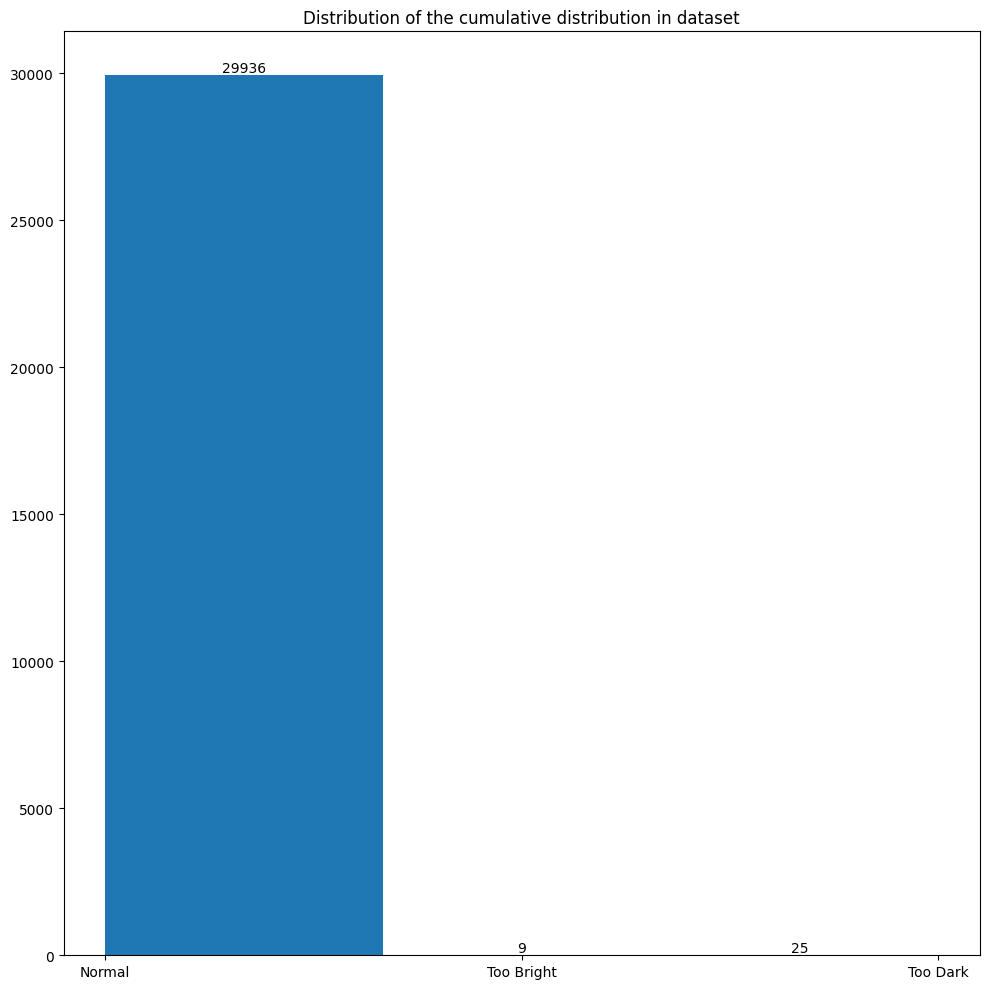

In [19]:
plt.figure(figsize=(10,10))
counts, edges, bars = plt.hist(df["brightness"], bins=3)

plt.title("Distribution of the cumulative distribution in dataset")
plt.bar_label(bars)
plt.tight_layout()
plt.show()

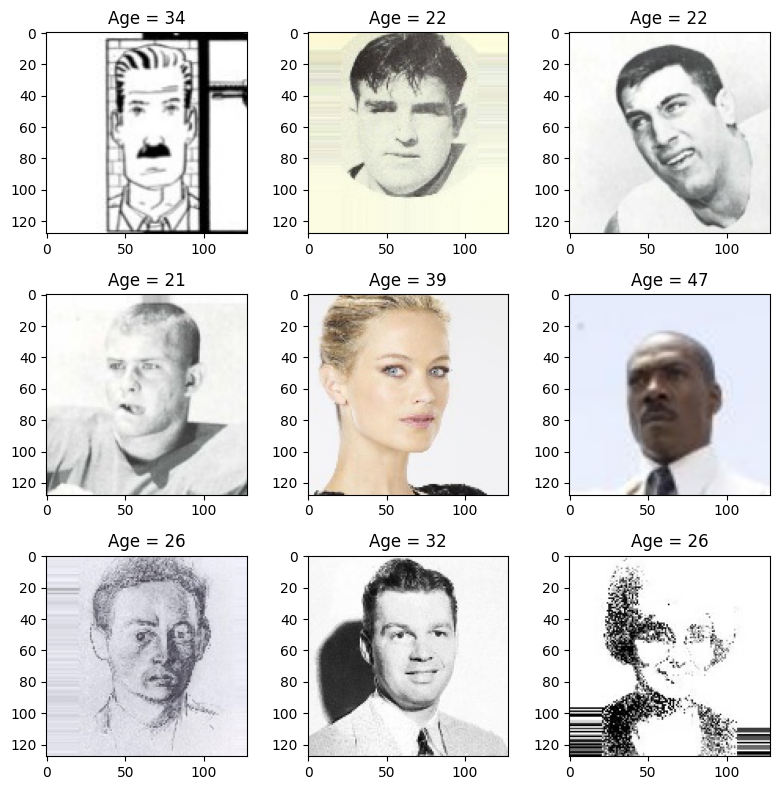

In [20]:
too_bright = df[df["brightness"] == "Too Bright"]
too_bright = too_bright.sample(n=9)

idx = 0
plt.figure(figsize=(8,8))
for i, display_path in enumerate(too_bright.path):
    display_img = Image.open(display_path)
    plt.subplot(3, 3, i+1)
    plt.title(f"Age = {too_bright.age.iloc[i]}")
    plt.imshow(display_img)
plt.tight_layout()
plt.show()


As we can see the imagery considered to have a brightness are typically seen as black and white imagery, with a couple of examples seen as drawings. 

Let's look at the identified dark imagery

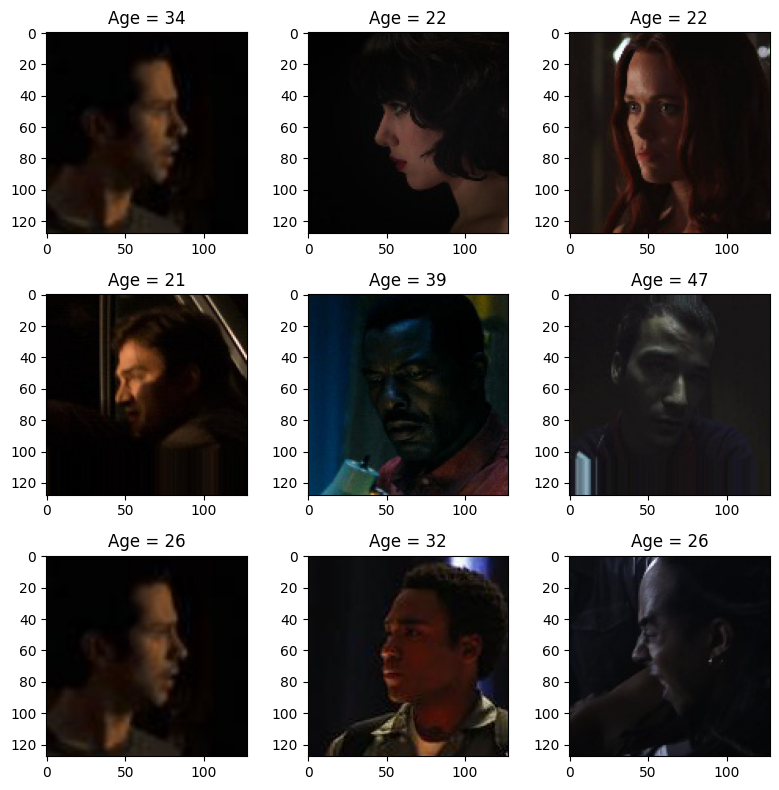

In [21]:
too_dark = df[df["brightness"] == "Too Dark"]
too_dark = too_dark.sample(n=9)

idx = 0
plt.figure(figsize=(8,8))
for i, display_path in enumerate(too_dark.path):
    display_img = Image.open(display_path)
    plt.subplot(3, 3, i+1)
    plt.title(f"Age = {too_bright.age.iloc[i]}")
    plt.imshow(display_img)
plt.tight_layout()
plt.show()

As we can see from the dark imagery, the imagery are very dark and/or contain a lot of shade. 

### Metadata Analysis

As determined earlier (under Distribution of width and height), we found that since the resolution and aspect ratio remain consistent throughout the dataset, we can't use this as a metric to filter out "low quality" imagery. 

However, let's see if the file size information of the dataset can provide any insights if low-quality examples exist based on low file size information

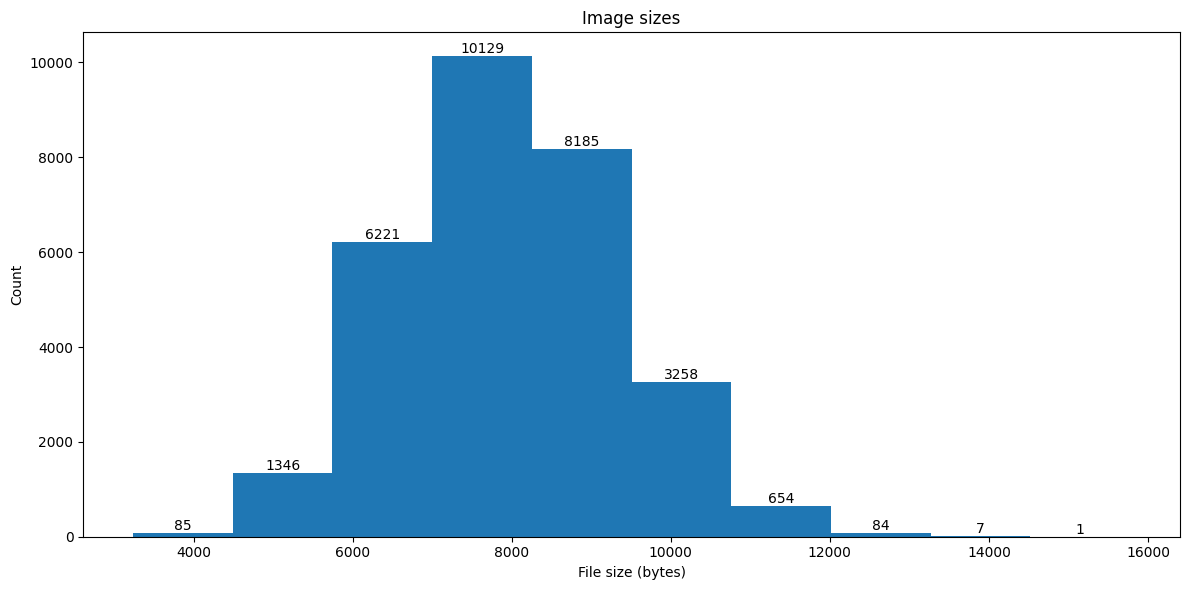

In [22]:
plt.figure(figsize=(12,6))
# df["size"].hist(color="blue", alpha = 0.6)
counts, edges, bars = plt.hist(df["size"])

plt.title("Image sizes")
plt.xlabel("File size (bytes)")
plt.ylabel("Count")
plt.bar_label(bars)

plt.tight_layout()
plt.show()

As we can see here, we have a bell-curve shaped graph with a slight skew to the right. Since we are looking for low-quality examples, let's look at a couple of random examples with the lowest bin

In [23]:
# Filter the dataframe by the lowest bucket in the histogram and randomly select 4 images
df.astype({"size": "float64"}).dtypes
df_subset = df[(df["size"] >= edges[0]) & (df["size"] <= edges[1])]
df_subset = df_subset.sample(n=4)
 

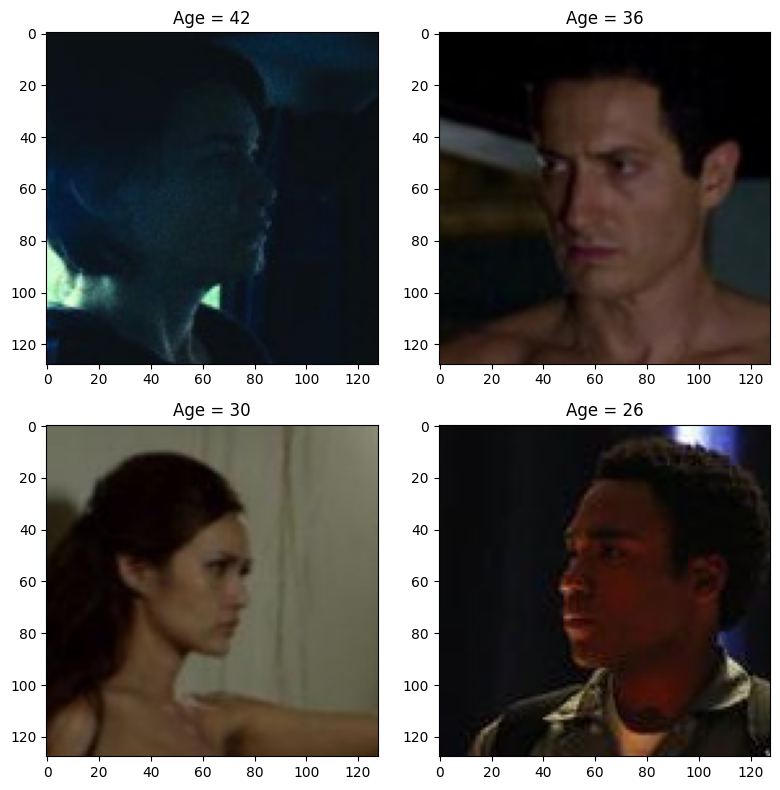

In [24]:
# Display the smapled images
idx = 0
plt.figure(figsize=(8,8))
for i, display_path in enumerate(df_subset.path):
    display_img = Image.open(display_path)
    plt.subplot(2, 2, i+1)
    plt.title(f"Age = {df_subset.age.iloc[i]}")
    plt.imshow(display_img)
plt.tight_layout()
plt.show()

There are certainly some lower quality images present but this doesn't seem consistent with the image file size.

## Save DataFrame

In [25]:
df.to_csv(df_path)

In [26]:
df

,image_id,filename,path,height,width,size,"image_mean([R,G,B])","st_dev([R,G,B])",image_mode,age,aspect_ratio,laplacian_var,brightness
0,0,122542,C:\Users\Jared\projects\python\braineye-age-pr...,128,128,8652,"[0.6380450129508972, 0.31967222690582275, 0.28...","[0.1845678985118866, 0.18805555999279022, 0.17...",RGB,20,1.0,1113.515213,Normal
1,1,122550,C:\Users\Jared\projects\python\braineye-age-pr...,128,128,9781,"[0.3353889286518097, 0.2767695486545563, 0.202...","[0.275545597076416, 0.19257135689258575, 0.186...",RGB,20,1.0,1639.238871,Normal
2,2,122573,C:\Users\Jared\projects\python\braineye-age-pr...,128,128,7770,"[0.6544163227081299, 0.6315654516220093, 0.548...","[0.25599220395088196, 0.2756023705005646, 0.24...",RGB,20,1.0,377.888782,Normal
3,3,122642,C:\Users\Jared\projects\python\braineye-age-pr...,128,128,4804,"[0.22364862263202667, 0.18860989809036255, 0.1...","[0.10604064166545868, 0.08799631893634796, 0.0...",RGB,20,1.0,185.784095,Normal
4,4,122646,C:\Users\Jared\projects\python\braineye-age-pr...,128,128,11211,"[0.44937387108802795, 0.43740808963775635, 0.3...","[0.2650805115699768, 0.27240049839019775, 0.28...",RGB,20,1.0,2360.912407,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29965,29965,99814,C:\Users\Jared\projects\python\braineye-age-pr...,128,128,7910,"[0.17300859093666077, 0.12947949767112732, 0.1...","[0.20211130380630493, 0.16090622544288635, 0.1...",RGB,50,1.0,1620.302140,Normal
29966,29966,99819,C:\Users\Jared\projects\python\braineye-age-pr...,128,128,8559,"[0.1891694962978363, 0.1776348054409027, 0.218...","[0.23028673231601715, 0.21333780884742737, 0.2...",RGB,50,1.0,2070.926402,Normal
29967,29967,99907,C:\Users\Jared\projects\python\braineye-age-pr...,128,128,6876,"[0.5533868670463562, 0.5229092836380005, 0.292...","[0.2174087017774582, 0.2374659925699234, 0.233...",RGB,50,1.0,599.539258,Normal
29968,29968,99983,C:\Users\Jared\projects\python\braineye-age-pr...,128,128,10369,"[0.48215118050575256, 0.3947139084339142, 0.33...","[0.3137766718864441, 0.267193078994751, 0.2336...",RGB,50,1.0,2070.207980,Normal
